In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    transport_modes, 
    trip_motives, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    id_col,
    get_feature_importances,
    save_features_per_num, 
    load_features_per_num,
    run_transferable_classification
    )

from codebase.data.load_odin import load_odin
run_ML = False
%load_ext autoreload
%autoreload 2

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
odin_df = load_odin()

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [3]:
df_all = apply_ignore_rules(odin_df, IGNORE_RULES)  # Apply ignore rules after filtering

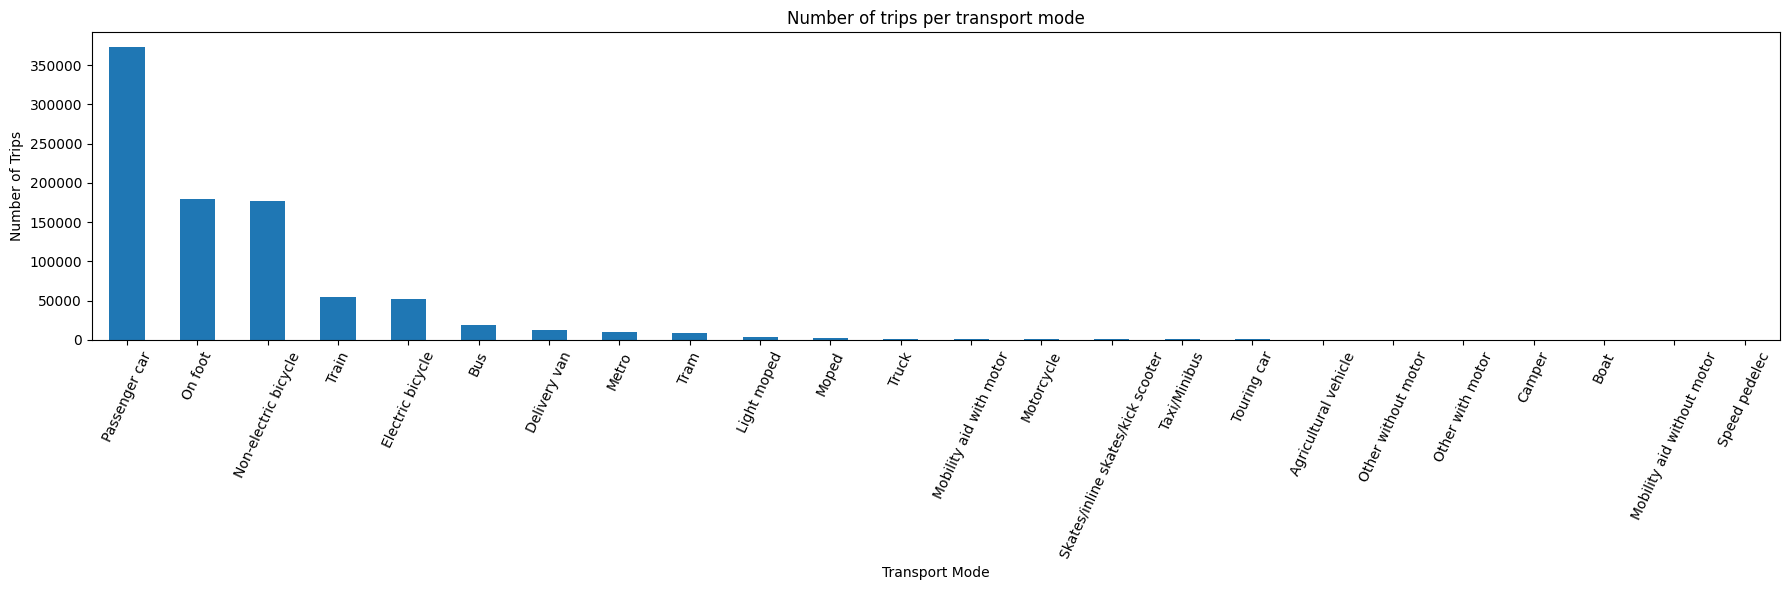

In [4]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df_all[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.6s finished


                                   precision    recall  f1-score   support

                    Passenger car       0.86      0.20      0.33     74576
                            Train       0.78      0.86      0.82     11216
                              Bus       0.39      0.56      0.46      3885
                             Tram       0.26      0.71      0.38      1785
                            Metro       0.37      0.46      0.41      2113
                    Speed pedelec       0.00      0.00      0.00         4
                 Electric bicycle       0.34      0.76      0.47     10638
             Non-electric bicycle       0.59      0.41      0.48     34747
                          On foot       0.74      0.44      0.55     36010
                      Touring car       0.03      0.18      0.05       153
                     Delivery van       0.08      0.47      0.14      1999
                            Truck       0.86      0.66      0.74       192
                        

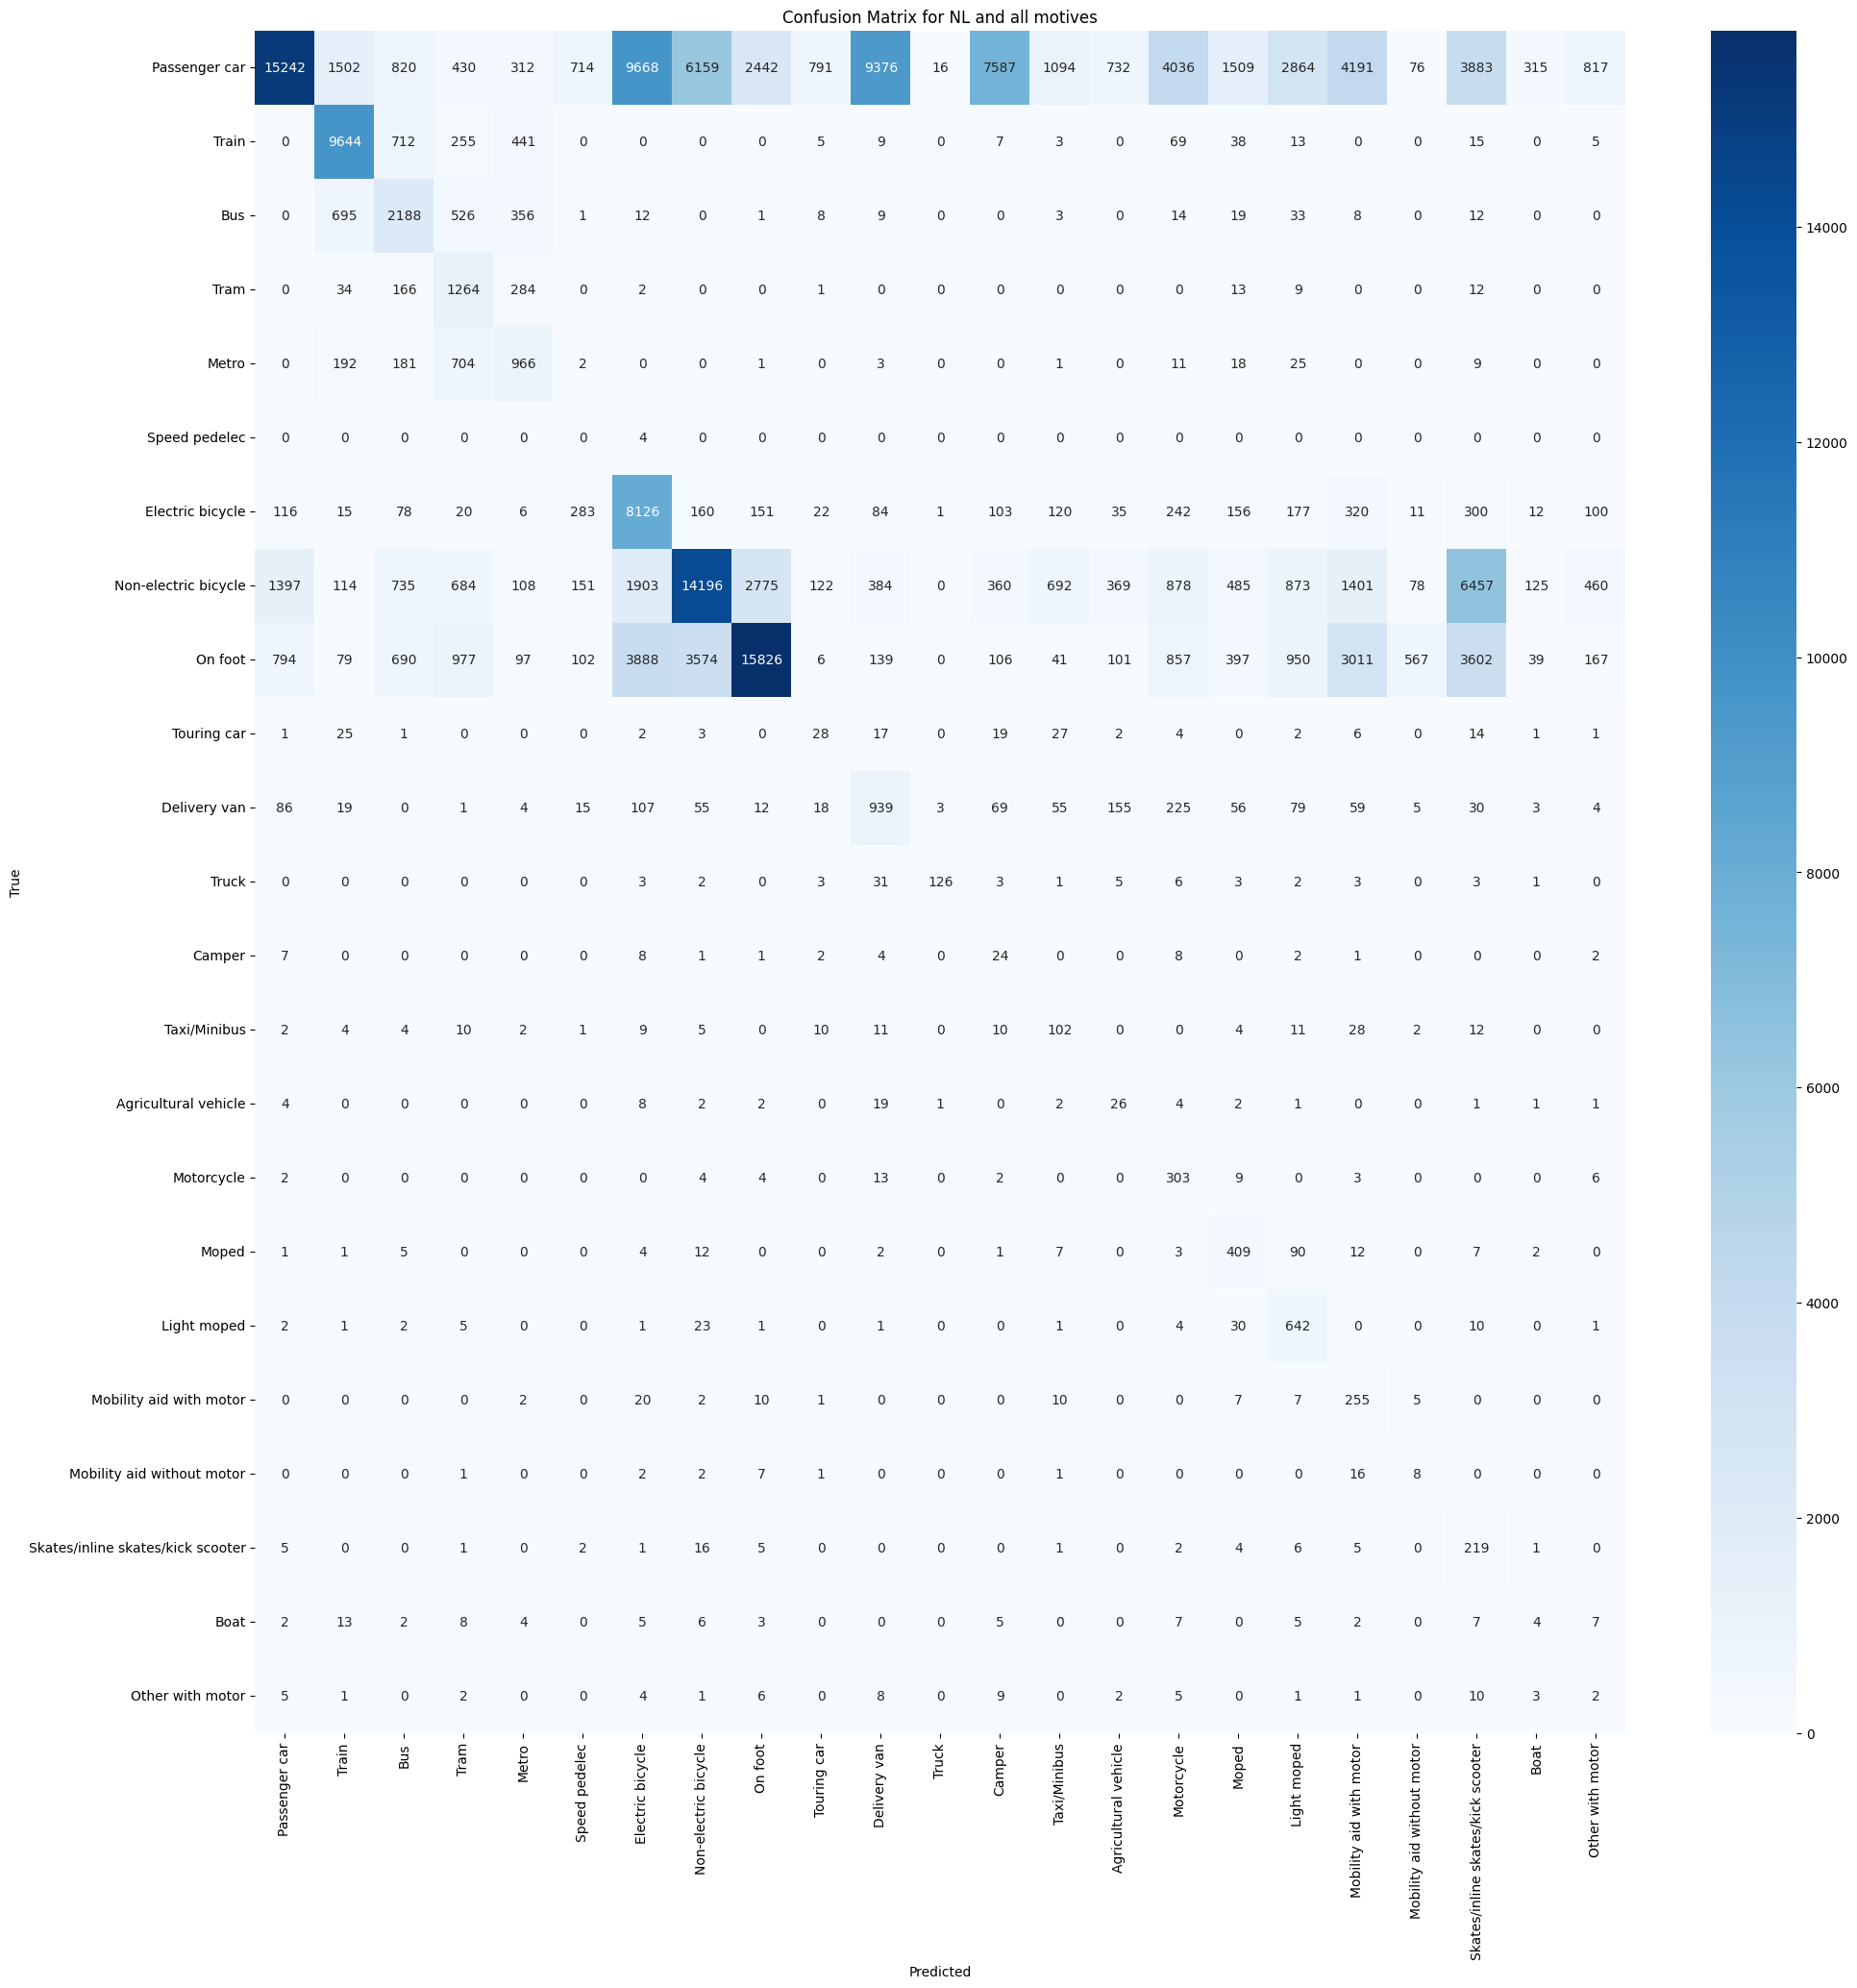

In [5]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

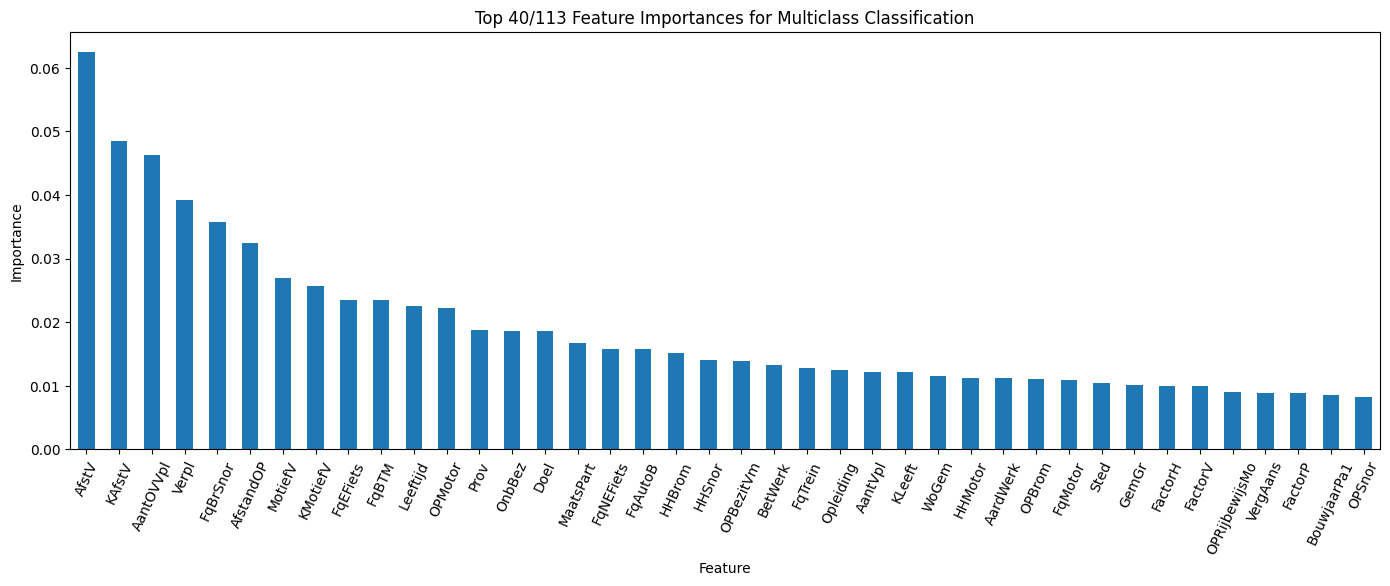

AankSPL       0.000960
AantOVVpl     0.046240
AantSVpl      0.001680
AantVpl       0.012129
AardWerk      0.011158
                ...   
VertSPL       0.001165
VolgWerk      0.003858
Weggeweest    0.000004
WoGem         0.011472
WrkVerg       0.002466
Length: 113, dtype: float64

In [6]:
get_feature_importances(pipeline_all["model"].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

In [7]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     74786
    Electric bicycle       0.38      0.89      0.54     10569
Non-electric bicycle       0.64      0.76      0.70     35597
             On foot       0.81      0.68      0.74     35916

            accuracy                           0.73    156868
           macro avg       0.68      0.76      0.69    156868
        weighted avg       0.78      0.73      0.74    156868



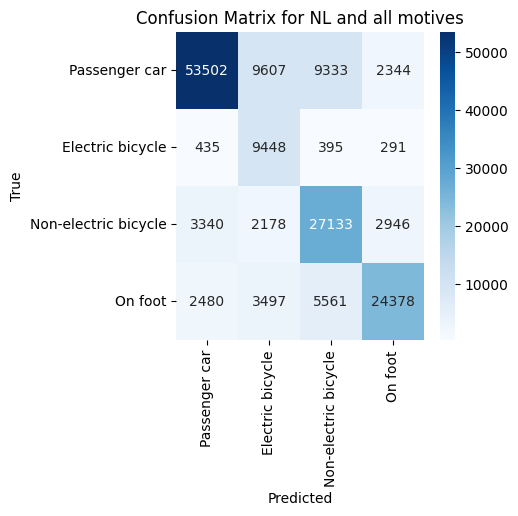

In [8]:
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

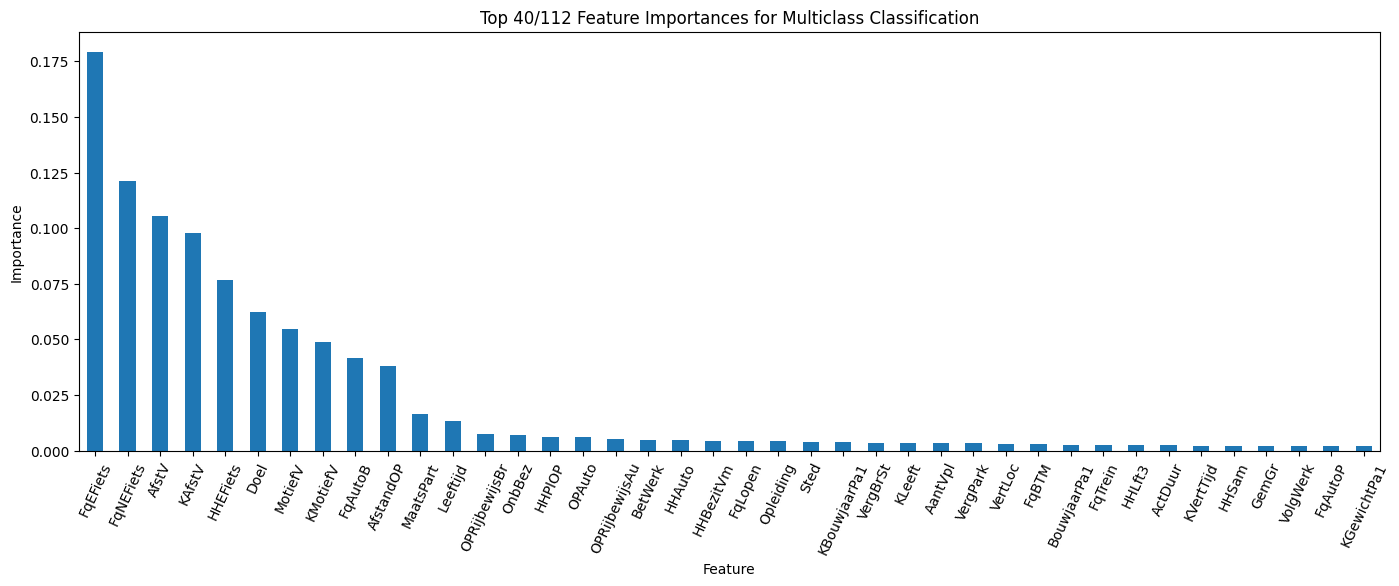

In [9]:
grouped_importances_less = get_feature_importances(pipeline_less["model"].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

Now keep the top N

In [10]:
"Hvm" in df_less_vehicles.columns

True

Decide whether or not to run the random forest loop with decreasing number of features present

In [11]:
overwrite = False

feature_savename = "data/features_per_num.pkl"
accs_savename = "data/accuracies_per_num.pkl"

In [12]:
if os.path.exists(feature_savename) and not overwrite:
    features_per_num, accs = load_features_per_num(feature_savename, accs_savename)
    nums = list(features_per_num.keys())
else:
    prev_grouped_importances = grouped_importances_less

    nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
    accs = []
    features_per_num = dict()

    for num_keep in nums:
        prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

        cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
        df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
        print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

        pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
            df_keep_loop,
            test_size=0.2,
            destinations=None,
            origins=origins,
            location_level=location_level,
            categorical_features=categorical_cols,
            motives=motives,
            plot=True,
            savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
            plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
            verbose=True,
        )


        prev_grouped_importances = get_feature_importances(
            pipeline_keep_loop["model"].feature_importances_, 
            column_names=X_train.columns, 
            top_n_for_plot=40, 
            savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
        )
        accs.append(accuracy)

        features_per_num[num_keep] = prev_grouped_importances
    save_features_per_num(features_per_num, accs, feature_savename, accs_savename)

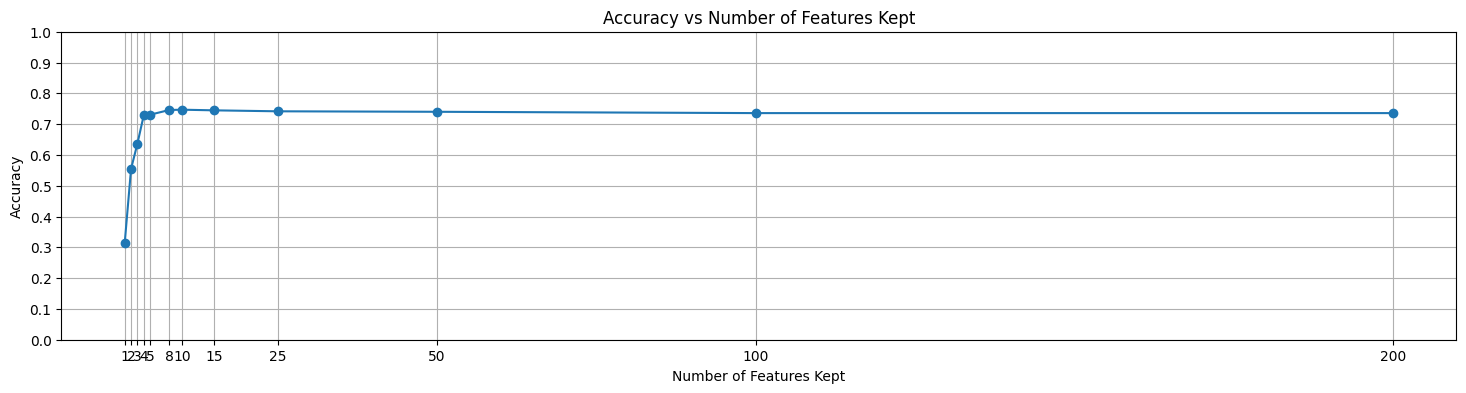

In [13]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.80     74786
    Electric bicycle       0.41      0.88      0.56     10569
Non-electric bicycle       0.64      0.78      0.70     35597
             On foot       0.80      0.71      0.76     35916

            accuracy                           0.74    156868
           macro avg       0.69      0.77      0.71    156868
        weighted avg       0.79      0.74      0.75    156868



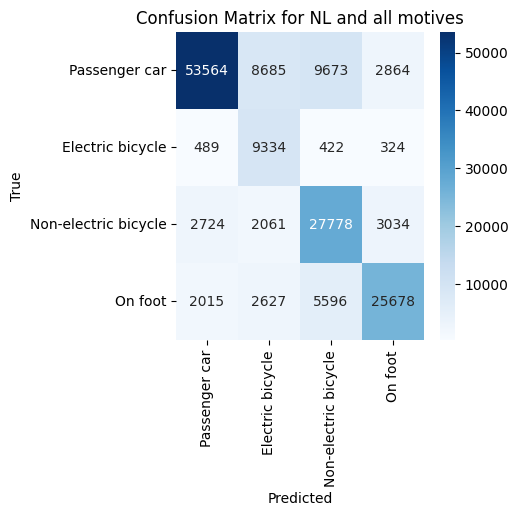

In [14]:
num_to_replicate = 10

# categorical_cols_for_small = [
#     urbanness_col, 
#     age_col,
#     distance_col,
#     motive_col,
#     "KAfstV",
#     "Doel"
# ] 

cols_to_keep = features_per_num[num_to_replicate].index.to_list() + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/transferable_forest_{num_to_replicate}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

File data/classification_results/multiclass/transferable_classification_results_7_6_50.csv already exists. Loading existing results.


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

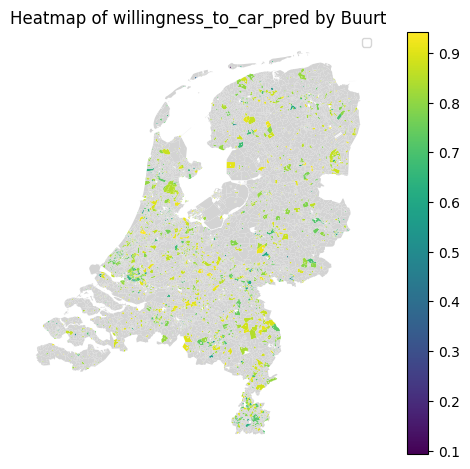

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

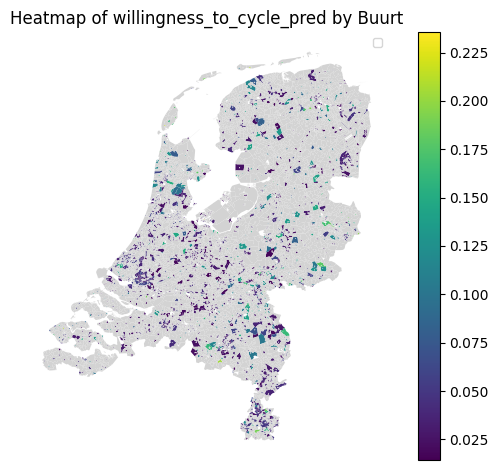

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

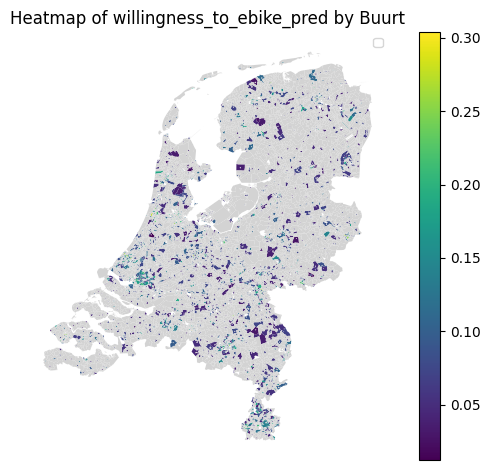

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize='small')
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small')


<Figure size 1000x1000 with 0 Axes>

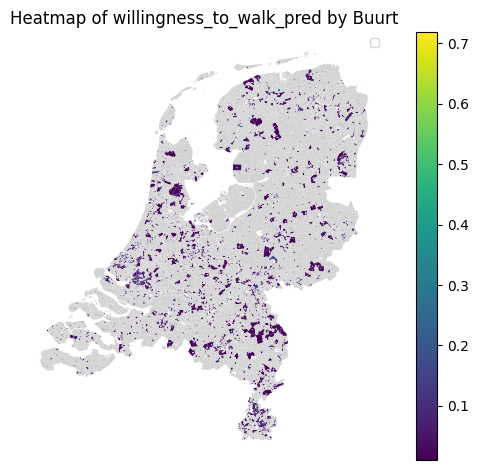

In [27]:
from codebase import run_transferable_classification
cols_for_transferable = features_per_num[num_to_replicate].index.to_list()

df_with_probs = run_transferable_classification(
    odin_df=df_all,
    pipeline_transferable=pipeline_transferable,
    cols_for_transferable=cols_for_transferable,
    necessary_columns=X_train.columns,
    col_car_pred = "willingness_to_car_pred",
    col_cycle_pred = "willingness_to_cycle_pred",
    col_ebike_pred = "willingness_to_ebike_pred",
    col_walk_pred = "willingness_to_walk_pred",
    threshold_datapoints=50,
    overwrite_existing=False
)